In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 5

# necessary modules -------------------------------------------------------------------------------------
import sys
import os
sys.path.append('/home/ollie/loziel/pyfesom2/')
sys.path.append('/home/ollie/loziel/pyfesom2/SkillMetrics')
sys.path.append('/home/ollie/loziel/pyfesom2/codes/py_f2recom_develop/GlobalAssessment/')
import skill_metrics as sm
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.colors as colors
import time
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# own py_recom modules ----------------------------------------------------------------------
# convert again if you changed something!
if True:
#    !jupyter nbconvert --to=python *.ipynb
    !jupyter nbconvert --to=python load_interp_WOA_python3.ipynb
    !jupyter nbconvert --to=python plot_Taylor_normalized.ipynb
    !jupyter nbconvert --to=python plot_Chlorophyll_FESOM_python3.ipynb
    !jupyter nbconvert --to=python F2R_sensitivity_toolbox.ipynb
from plot_Chlorophyll_FESOM_python3 import plot_Chl
from F2R_sensitivity_toolbox import mygrid

Autosaving every 5 seconds
[NbConvertApp] WARNING | pattern 'load_interp_WOA_python3.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--st

[NbConvertApp] WARNING | pattern 'plot_Chlorophyll_FESOM_python3.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--debug
    set log level to logging.DEBUG (maximize logging output)
--generate-config
    generate default config file
-y
    Answer yes to any questions instead of prompting.
--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with default basename 'notebook.*'
--stdout
    Write noteb

In [2]:
# After changing these parameters here, save the notebook and clear the output. 
# Then run this cell and the cells with the desired parameters.

# run specification -------------------------------------------------------------------------------------   
if True:
    runid      =  'fesom'
    #resultpath = '/work/ollie/loziel/model_output/fesom2.1_recom/B_spinup_riv'
    resultpath = '/work/ollie/ogurses/output_f2r2/spinup_1800_1850/A'
    #meshpath = '/work/ollie/loziel/mesh/core2_meanz/'
    meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'
    # period of analysis 
    first_year = 1970
    last_year  = 2017
    
years = np.arange(first_year,last_year+1,1)
years_last10 = np.arange(last_year-10,last_year+1,1)

# specification of analysis ------------------------------------------------------------------------------------

layerwise = False
depths = (0,50,200,1000,2000) # If layerwise is True, you can define depths here, by defaut: (0,50,200,1000,2000,4000)
depth_limit = 200
mapproj = 'pc'
#Map projection. Options are Mercator (merc), Plate Carree (pc),
#North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
#Robinson projection is quite time consuming.

# export of analysis ------------------------------------------------------------------------------------
today = date.today().strftime("_%Y_%m_%d")

savepath = '/home/ollie/loziel/pyfesom2/outputs/B_spinup_riv/'
savefig = False
htmlname     =  'B_spinup_riv' + today +'.html'
htmlpath = '/home/ollie/loziel/pyfesom2/outputs/B_spinup_riv/'
verbose = False

if not os.path.exists('htmlpath'): # create folders if do not exist
    os.makedirs('htmlpath')
if not os.path.exists('savepath'):
    os.makedirs('savepath')
    
# initialization file specifications -----------------------------------------------------------

obspath      = '/home/ollie/mseifert/py_fesom/CreateRunFiles/Initialization/Output/'

ncfileAlk                = '/work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TAlk.nc'
ncfileDIC                = '/work/ollie/projects/MarESys/evaluation/GLODAPv2.2016b.TCO2.nc'
ncfileDSi                = '/work/ollie/projects/MarESys/evaluation/woa13_all_i00_01.nc'
ncfileDIN                = '/work/ollie/projects/MarESys/evaluation/woa13_all_n00_01.nc'
ncfileDO2                = '/work/ollie/projects/MarESys/evaluation/woa18_all_o00_01.nc'
ncfileDFe                = '/work/ollie/projects/MarESys/evaluation/fe_pisces_opa_eq_init_3D.nc' 
ncfileNPPTotalGlobal     = '/work/ollie/projects/MarESys/evaluation/'+'fesom.initial.mesh.diag.nc'
ncfileCO2fluxTotalGlobal = '/work/ollie/projects/MarESys/evaluation/'+'fesom.initial.mesh.diag.nc'
ncfileTemp               = '/work/ollie/projects/MarESys/evaluation/woa18_decav_t00_01.nc'
ncfileSal                = '/work/ollie/projects/MarESys/evaluation/woa18_decav_s00_01.nc'
ncfilePHC3               = '/work/ollie/ogurses/input/phc3.0_annual.nc'      
ncfilepCO2               = '/work/ollie/projects/MarESys/evaluation/SOCATv6_tracks_gridded_monthly.nc'
ncfileMLD                = '/work/ollie/projects/MarESys/evaluation/mld_DR003.nc'
matfileChlsurf           = '/work/ollie/projects/MarESys/evaluation/climatology_annual_chl_1deg_OCCCI_2012_2015.mat'
txtfileCO2flux           = '/work/ollie/projects/MarESys/evaluation/CO2_flux2015_Takahashietal2009_original.txt'

ncfileMaredat = "/home/ollie/mozeisin/obs/MarEDat/MarEDat20120716Diatoms.nc"
pathJohnson2013 = '/home/ollie/mozeisin/obs/Johnson2013_Chl_SouthernOcean/'

# just to check
if(verbose):
    print('Processing years {4} to {5}\n\nReading out of {0}\nStoring graphs to {1}\nStoring html to {2} as {3}'.format(
        resultpath, savepath, htmlpath, htmlname,years[0],years[-1]))

    print('\nLast ten years are \n{0}'.format(years_last10))
    
# mesh initialization -----------------------------------------------------------
# mesh = pf.load_mesh(meshpath)  

if(verbose):
    print(mesh_depths)
    print(diag)

/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz/pickle_mesh_py3_fesom2
/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz/pickle_mesh_py3_fesom2
***
Loading SOCAT file: /work/ollie/projects/MarESys/evaluation/SOCATv6_tracks_gridded_monthly.nc
***
!!! Careful, SOCAT is extrapolated, it will be fixed in a further version !!!

Plotting pCO2
FESOM min = 195.16134643554688, max = 1183.8048095703125
SOCAT min = 121.06995391845703, max = 1949.37451171875

Original Taylor stats:
SDEV pred: 40.65004, ref: 45.07269
CRMS pred: 41.08819, ref: 0.00000
CORRCOEF: 0.54463

Normalized Taylor stats:
SDEV pred: 0.90188, ref: 1.00000
CRMS pred: 0.91160, ref: 0.00000
CORRCOEF: 0.5446

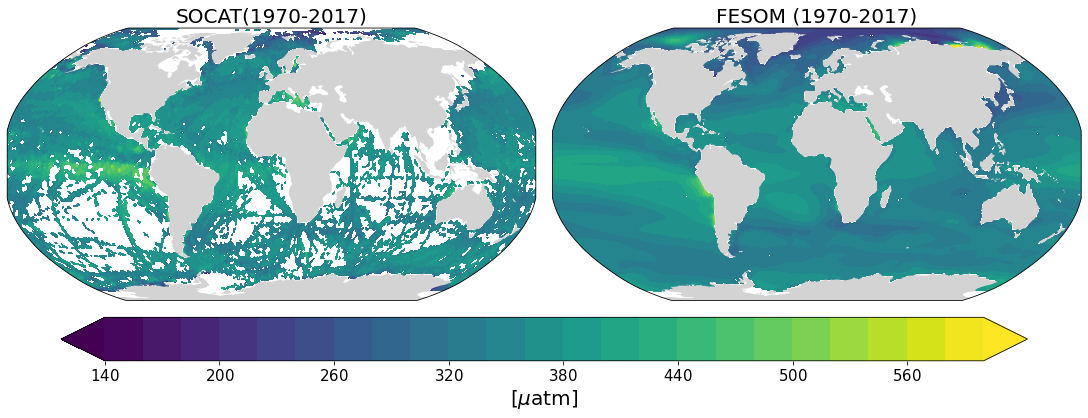

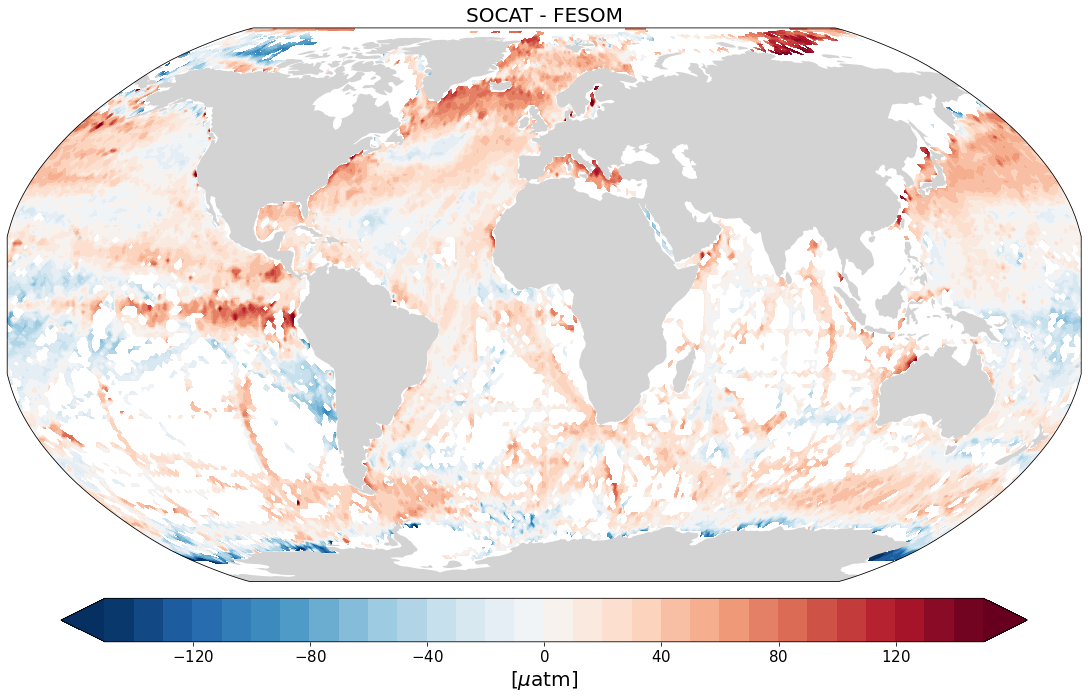

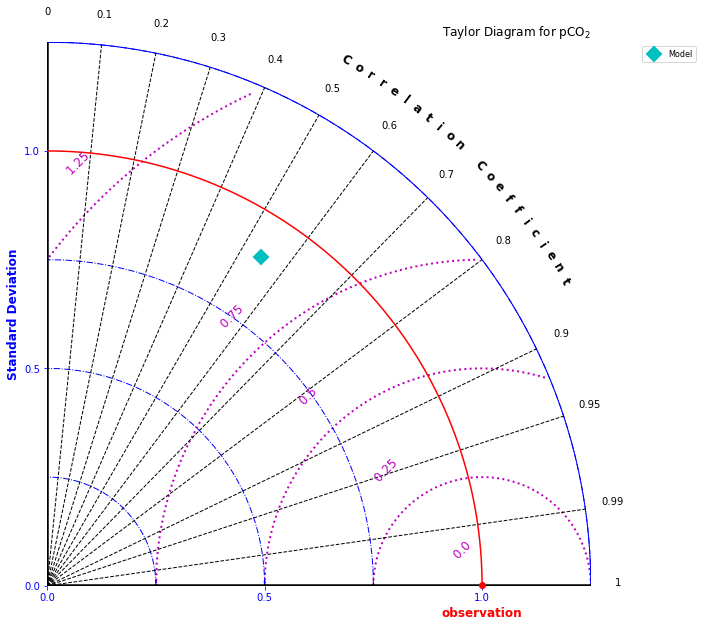

In [4]:
# !jupyter nbconvert --to=python pCO2SOCAT_python3.ipynb
# !jupyter nbconvert --to=python load_interp_SOCAT_python3.ipynb
from pCO2SOCAT_python3 import pCO2comp

test = pCO2comp(runid,resultpath,savepath,meshpath,ncfilepCO2,first_year,last_year,
                mapproj='rob',
                savefig=savefig)